In [191]:
import jax
import jax.numpy as jnp
import numpy as np
import optax

BATCH_SIZE = 5
NUM_TRAIN_STEPS = 1_000

In [192]:
h = 5
initial_params = {
    'W1': jax.random.normal(shape=[1, h], key=jax.random.PRNGKey(0)),
    'B1': jax.random.normal(shape=[1, h], key=jax.random.PRNGKey(1)),
    'W2': jax.random.normal(shape=[h, 1], key=jax.random.PRNGKey(2)),
    'B2': jax.random.normal(shape=[1, 1], key=jax.random.PRNGKey(3)),
}

def net(params: jnp.ndarray, x: jnp.ndarray, ) -> jnp.ndarray:
    x = jnp.dot(x, params['W1']) + params['B1']
    x = jax.nn.sigmoid(x)
    x = jnp.dot(x, params['W2']) + params['B2']
    # TODO: if x.shape = (1,) then return scalar Array
    # x.shape = (BATCH_SIZE, 1)
    return x

# check
x = np.random.random_sample(size=(BATCH_SIZE, 1))
print(f'x.shape = {x.shape}')
net(initial_params, 2.0)

x.shape = (5, 1)


Array([[0.6609231]], dtype=float32)

In [ ]:
m = 1.
c = 0.1
k = 1.
y0 = 1.
y0_prime = 0.

def ode(params, t):
    # nn = lambda t: jnp.reshape(net(t, params), ())
    nn = lambda t: net(params, t)
    dnn = jax.grad(nn)
    ddnn = jax.grad(dnn)
    return m * ddnn(t) + c * dnn(t) + k * nn(t)

# check
ode(initial_params, 3.0)

In [174]:
def loss(params: optax.Params, batch: jnp.ndarray) -> jnp.ndarray:
    # nn = lambda t: jnp.reshape(net(t, params), ())
    # dnn = jax.grad(nn)

    y_hat = ode(params, batch)
    ode_loss = jnp.mean(y_hat ** 2)
    init_loss_1 = (net(params, 0.) - y0) ** 2
    init_loss_2 = (dnn(0.) - y0_prime) ** 2

    return jnp.sum(ode_loss, init_loss_1, init_loss_2)
    #return ode_loss

# check
#loss(x, initial_params)

In [ ]:
#TRAINING_DATA = jnp.linspace(0, 20, 1000*BATCH_SIZE)
#t = jnp.reshape(TRAINING_DATA, newshape=(NUM_TRAIN_STEPS, BATCH_SIZE, 1))
key = jax.random.PRNGKey(42)
t = jnp.linspace(0, 20, 1000)

def fit(params: optax.Params, optimizer: optax.GradientTransformation, key) -> optax.Params:
  opt_state = optimizer.init(params)

  @jax.jit
  def step(params, opt_state, batch):
    loss_value, grads = jax.value_and_grad(loss)(params, batch)
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss_value

  # for i, batch in enumerate(t):
  #   params, opt_state, loss_value = step(params, opt_state, batch)
  #   if i % 100 == 0:
  #     print(f'step {i}, loss: {loss_value}')

  for epoch in range(1000):
      shuffle_key, key = jax.random.split(key)
      batches = jax.random.permutation(shuffle_key, t)
      batches = batches.reshape(-1, BATCH_SIZE)
      for batch in batches:
          params, opt_state, loss_value = step(params, opt_state, batch.reshape(BATCH_SIZE, 1))
      if epoch % 100 == 0:
          print(f'epoch {epoch}, loss: {loss_value}')

  return params

optimizer = optax.adam(learning_rate=1e-2)
train_key, key = jax.random.split(key)
params = fit(initial_params, optimizer, key)


In [ ]:
def sol(t):
    r1 = - c / (2 * m) + 1 / (2*m) * (c ** 2 - 4 * k * m) ** (1 / 2)
    r2 = - c / (2 * m) - 1 / (2*m) * (c ** 2 - 4 * k * m) ** (1 / 2)
    c2 = r1 / (r1 - r2)
    c1 = 1 - c2
    return c1 * jnp.exp(r1 * t) + c2 * jnp.exp(r2 * t)

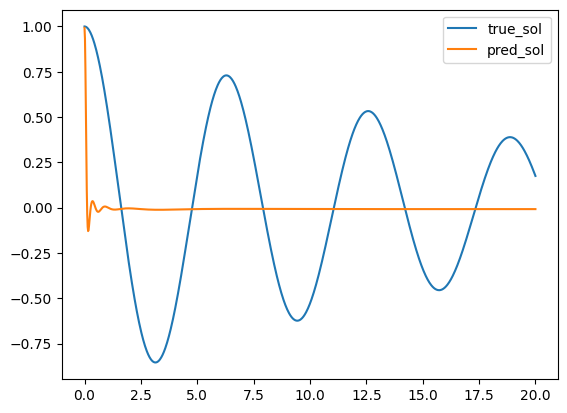

In [ ]:
import matplotlib.pyplot as plt


plt.plot(t, jnp.real(sol(t)), label='true_sol')
plt.plot(t, net(t.reshape((1000,1)), params), label='pred_sol')
plt.legend()